# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Getting unique Users via E-Mail
unique_users = len(list(df.email.unique()))
print(unique_users)

articles_total = df.article_id.count()
print(articles_total)

# Avg. articles read by unique user
print(articles_total / unique_users)

5149
45993
8.932414060982715


In [4]:
# Taking a closer look at unique e-mails

len(df[df["email"].notnull()]["email"].unique().tolist())

5148

In [5]:
# Already mapping E-Mails to generate User_IDs making further calculations easier

In [6]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [7]:
# Converting dtype of user id column from int64 to object for further analysis
print(df.dtypes)
df["user_id"] = df["user_id"].astype('str')
print(df.dtypes)


article_id    float64
title          object
user_id         int64
dtype: object
article_id    float64
title          object
user_id        object
dtype: object


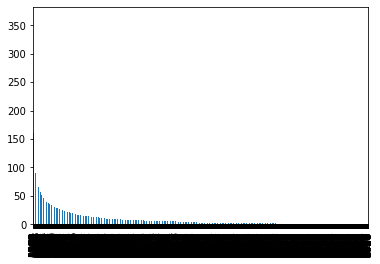

In [8]:
# Plotting distribution

df['user_id'].value_counts().plot(kind='bar')

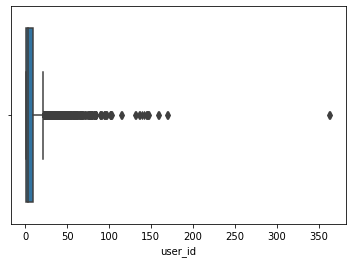

In [9]:
import seaborn as sns

ax = sns.boxplot(x=df['user_id'].value_counts())

[(0, 50)]

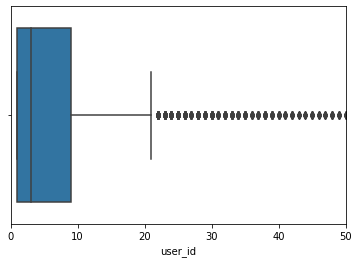

In [10]:
# Zooming in on x-axis

ax = sns.boxplot(x=df['user_id'].value_counts())
ax.set(xlim=(0, 50))

In [11]:
# Describing user_id numerically on top of visualizing it above

df['user_id'].value_counts().describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: user_id, dtype: float64

In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [13]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [14]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [15]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [16]:
# Find and explore duplicate articles

# Checked: 
# https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/
df_content[df_content.duplicated("article_id")]


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [17]:
# Printing all duplicate articles

df_content[df_content["article_id"].isin([50,221,398,577,232])]

# Apparently duplicate articles only contain different doc_descriptions but the rest is the same. So can drop duplicates

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [18]:
# Remove any rows that have the same article_id - only keep the first

In [19]:
## Iterating over all article_ids and grabbing index of duplicate rows 

keep_articles = []
remove_articles = []

for article in df_content["article_id"]:
    if int(article) not in keep_articles:
        keep_articles.append(int(article))
    elif int(article) in keep_articles:
        remove_articles.append(int(article))

print(len(df["article_id"]))
print(len(keep_articles))
print(len(remove_articles))
    

45993
1051
5


In [20]:
# Checking shape of df_content before dropping duplicate articles

df_content.shape

(1056, 5)

In [21]:
# Dropping duplicate articles based on id while keeping the first occurence of the article

df_content = df_content.drop(remove_articles,axis=0)

In [22]:
# Checking shape of df_content after dropping rows

df_content.shape

# Dropping successful

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [23]:
len(df_content["article_id"].to_list())

1051

In [24]:
# a. The number of unique articles that have an interaction with a user. 

df["article_id"].nunique()

714

In [25]:
# b. The number of unique articles in the dataset (whether they have any interactions or not). 

df_content["article_id"].describe()

# 1051


count    1051.000000
mean      525.001903
std       303.541631
min         0.000000
25%       262.500000
50%       525.000000
75%       787.500000
max      1050.000000
Name: article_id, dtype: float64

In [26]:
# c. The number of unique users in the dataset. (excluding null values)

df["user_id"].nunique()

5149

In [27]:
# d. The number of user-article interactions in the dataset.

df.info()

# 45993

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
user_id       45993 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [28]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

4. Use the cells below to find the most viewed article_id, as well as how often it was viewed. After talking to the company leaders, the email_mapper function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [29]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [30]:
df.groupby("article_id").size().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1210.0      2
1226.0      2
1227.0      2
1067.0      2
1230.0      2
1137.0      2
1135.0      2
1235.0      2
1251.0      2
364.0       2
1130.0      2
1244.0      2
1127.0      1
675.0       1
1119.0      1
653.0       1
662.0       1
974.0       1
1344.0      1
1113.0      1
724.0       1
1072.0      1
1266.0      1
1200.0      1
1202.0      1
1233.0      1
1237.0      1
417.0       1
984.0       1
1092.0      1
Length: 714, dtype: int64

In [31]:
df.query("article_id == 1429")

,article_id,title,user_id
2,1429.0,use deep learning for image classification,3
6,1429.0,use deep learning for image classification,7
41,1429.0,use deep learning for image classification,3
75,1429.0,use deep learning for image classification,7
80,1429.0,use deep learning for image classification,40
136,1429.0,use deep learning for image classification,6
284,1429.0,use deep learning for image classification,7
303,1429.0,use deep learning for image classification,87
334,1429.0,use deep learning for image classification,87
369,1429.0,use deep learning for image classification,21


In [32]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [33]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [34]:
def get_ranked_articles(n, df=df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    ranked_articles - (pandas dataframe) containing top (n) ranked video_ids and titles
    '''
    ranked_articles = df.groupby(["article_id","title"]).size().sort_values(ascending=False)
    ranked_articles = ranked_articles.to_frame().reset_index()
    ranked_articles = ranked_articles.iloc[:n]

    return ranked_articles
    

In [35]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ranked_articles = get_ranked_articles(n, df)
    top_articles = ranked_articles["title"].to_list()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ranked_articles = get_ranked_articles(n, df)
    top_articles = ranked_articles["article_id"].to_list()
 
    return top_articles # Return the top article ids

In [36]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [37]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [38]:
# Checking for amount of unique entries

print(df.drop_duplicates(subset="user_id").nunique())

print(df.nunique())

article_id     560
title          560
user_id       5149
dtype: int64
article_id     714
title          714
user_id       5149
dtype: int64


In [39]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # introducing helper column, and assigning 1's to all user, article interactions
    df["interacted"] = 1
    
    # Reshaping Matrix so that users are displayed as rows and article ids as columns
    # checked: https://stackoverflow.com/questions/39648991/pandas-dataframe-pivot-memory-error
    user_item = df.groupby(["user_id","article_id"])["interacted"].max().unstack()
    user_item.index = user_item.index.astype("int64")
    
    # filling empty values with 0's
    user_item.fillna(0,inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [40]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [42]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_array = user_item.to_numpy()
    user_item_array_transp = np.transpose(user_item_array)    
    user_similarity = np.dot(user_item_array, user_item_array_transp)
    user_row_idx = user_item.index.get_loc(user_item.loc[user_id].name)
    
    # sort by similarity

    similar_users_ranked = user_similarity[int(user_row_idx)]

    # create list of just the ids
    
    ## Checked: https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    
    ## Returns column index of most similar users. Since it is a transposed matrix where row and column indices match, 
    ## can interpret it as the row index 

    ranked_users_idxs = (-similar_users_ranked).argsort()
   
    # remove the own user's id
    
    ## Since the own user's id is always the highest ranked one, can just remove the first ID in the numpy array

    most_similar_users = np.delete(ranked_users_idxs,[0])
    
    most_similar_users = most_similar_users.tolist()

    return most_similar_users # return a list of the users in order from most to least similar


In [43]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3260, 1445, 3092, 1146, 3844, 3190, 346, 4000, 3559, 4492]
The 5 most similar users to user 3933 are: [3260, 1445, 3092, 3844, 1146]
The 3 most similar users to user 46 are: [4000, 1445, 3092]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [44]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Setting column article_id to int64 as opposed to float which has been given

    article_ids = [int(float(x)) for x in article_ids]

    article_names = []

    for article in article_ids:
        article_name = df.query("article_id == @article")["title"].unique()[0]
        article_names.append(article_name)   

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.values.tolist()
    article_ids = [str(float(x)) for x in article_ids]
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
   
    # Find all article_ids the user has seen
    user_articles_seen = get_user_articles(user_id, user_item=user_item)[0]

    # Get most similar users
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    
    # Store Article IDs seen by similar users in list until m is reached
    found_article_idx = []
    for similar_user in most_similar_users: 
        similar_user_articles_seen = get_user_articles(similar_user, user_item=user_item)[0]

        for article in similar_user_articles_seen:
            if article not in user_articles_seen:
                found_article_idx.append(article)
                # Break when enough recs were found. 

                if len(found_article_idx)  >= m:
                    break                 
        # https://stackoverflow.com/questions/653509/breaking-out-of-nested-loops
        else:
            continue
        break

    recs = found_article_idx

    return recs # return your recommendations for this user_id    

In [45]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['how to choose a project to practice data science',
 'intents & examples for ibm watson conversation',
 'simple graphing with ipython and\xa0pandas',
 'brunel 2.0 preview',
 'brunel interactive visualizations in jupyter notebooks',
 'use spark for scala to load data and run sql queries',
 'how to map usa rivers using ggplot2',
 'interconnect with us',
 'practical tutorial on random forest and parameter tuning in r',
 'dsx: hybrid mode']

In [46]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Creating Neighbors Dataframe as skeleton
    neighbors_df = pd.DataFrame(columns=["neighbor_id"])

    # Filling in neighbor_id values based on user_item index values

    neighbors_df["neighbor_id"] = user_item.index.values

    # Calculating Similarity for given user and all users in user_item based on dot_product

    similarity = pd.DataFrame(np.dot(user_item,user_item.loc[user_id]),index=user_item.index)

    # Adding calculated similarity to neighbors_df

    neighbors_df = pd.merge(neighbors_df,similarity,how="left",left_on="neighbor_id",right_on="user_id")

    # Calculating total article interactions for all users and adding to neighbors_df
    user_article_interactions_df = df.groupby(["user_id"]).sum().reset_index()
    user_article_interactions_df.user_id = user_article_interactions_df.user_id.astype("int64")
    
    neighbors_df = pd.merge(neighbors_df,user_article_interactions_df,how="left",left_on = "neighbor_id", 
                            right_on = "user_id")

    neighbors_df = neighbors_df[["neighbor_id",0,"interacted"]]

    neighbors_df.rename(columns = {0: "similarity"},inplace=True)

    # Sorting values in neighbors_df and returning dataframe without first row because it contains the given user itself
    neighbors_df = neighbors_df.sort_values(["similarity","interacted"],ascending=False).iloc[1:]

    return neighbors_df # neighbors_df Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.
    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get all articles the selected user has already seen
    user_articles_seen = get_user_articles(user_id)[0]

    # Get most similar users for given user id
    most_similar_users = get_top_sorted_users(user_id)["neighbor_id"].tolist()

    # Iterate over users in most similar users 
    for user_id in most_similar_users:
        # Get all article_ids for articles the similar user has seen and write to dataframe
        article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.values.tolist()
        article_ids_df = pd.DataFrame([str(float(x)) for x in article_ids],columns=["article_id"])
        article_ids_df["article_id"] = article_ids_df["article_id"].astype("float64")

        # Get general amount of interactions per article_id over all users 
        ranked_articles = df.groupby("article_id").sum().reset_index()

        # merging ranked_articles with article ids the current neighbor has seen. Return only seen articles in dataframe
        ranked_articles = pd.merge(article_ids_df,ranked_articles,how="left",on="article_id")

        # sorting seen articles so that articles with more interactions are returned first 
        ranked_articles = ranked_articles.sort_values("interacted",ascending=False)
        ranked_articles = ranked_articles.article_id.tolist()
        ranked_articles

        # Store Article IDs seen by similar users in list until m is reached
        found_article_idx = []
        for article in ranked_articles:
            if article not in user_articles_seen:
                found_article_idx.append(article)
                # Break when enough recs were found. 
                if len(found_article_idx)  >= m:
                    break                 
        # https://stackoverflow.com/questions/653509/breaking-out-of-nested-loops
        else:
            continue
        break

    recs = found_article_idx

    rec_names = get_article_names(recs)
    
    return recs, rec_names



In [49]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [50]:
print(get_top_sorted_users(1)[0:10])
print(get_top_sorted_users(131)[0:11])

      neighbor_id  similarity  interacted
3260         3933        35.0          45
1445           23        17.0         364
3092         3782        17.0         363
1146          203        15.0         160
3844         4459        15.0         158
346           131        14.0         145
3190         3870        14.0         144
4000           46        13.0          63
3559         4201        13.0          61
4333           49        12.0         147
      neighbor_id  similarity  interacted
3190         3870        74.0         144
3092         3782        39.0         363
1445           23        38.0         364
1146          203        33.0         160
3844         4459        33.0         158
5127           98        29.0         170
3072         3764        29.0         169
4333           49        29.0         147
2997         3697        29.0         145
1579          242        25.0         148
3235         3910        25.0         147


In [51]:
### Tests with a dictionary of results

user1_most_sim = 3933
user131_10th_sim = 242

In [52]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

With a new user we face the cold start problem. For these new users we can only come up with knowledge or content based recommendations. Therefore we could use "get_top_articles" which provides a list of the overall most read articles to begin with. We could also establish a content based approach, by requesting the user interests via an initial questionnaire or allows for filtering. We then would need to come up with an algorithm which filters articles by categories and recommends the most interacted with articles per category etc.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [53]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs_raw = get_ranked_articles(10)['article_id'].tolist()
new_user_recs = [str(float(x)) for x in new_user_recs_raw]

print(new_user_recs)




['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [54]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

#### Skipping this part

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# Load the matrix here
user_item_matrix = pd.read_pickle('./data/user_item_matrix.p')

In [56]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [57]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

In [58]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


We can use SVD as opposed to FUNK SVD, since we are dealing with a Matrix which is based on binary values. The matrix only tells us, whether a user has interacted with an article or not (0 or 1). Therefore we have valid values in each row and column of the matrix and no missing values, which is the prerequisite for applying SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

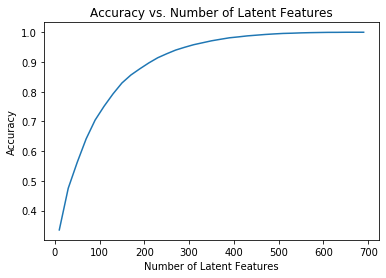

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
      
    
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [61]:
# Printing length of the lists to answer belows questions
print(len(user_item_train))
print(len(user_item_test))
print(len(test_idx))
print(len(test_arts))

4487
682
682
574


In [62]:
# Checking which USERS are present in test and training set and getting the length of the result set

len(set(df_train.user_id.unique()) & set(df_test.user_id.unique()))

20

In [63]:
# Checking which ARTICLES are present in test and training set and getting the length of the result set

len(set(df_train.article_id.unique()) & set(df_test.article_id.unique()))

574

In [64]:
user_item_test[user_item_test.sum(axis=1) == 0 ].sum(axis=1)

Series([], dtype: float64)

In [65]:
article_zeros = user_item_test.sum(axis=0) == 0
article_zeros[article_zeros == True]

Series([], dtype: bool)

In [66]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

# TO Reviewer: 
# Had to correct the below strings to match the string which is used in project_tests.py, 
# Else it leads to the following error

# KeyError: 'How many movies can we make predictions for in the test set?'

# This issue is also mentioned in this forum entry. https://knowledge.udacity.com/questions/57271
# After replacing "movies" by "articles" below the text passes as suggested in the forum.  


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [67]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [68]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [69]:
user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
u_train.shape

(4487, 4487)

In [71]:
# Then find the subset of rows in the user_item_test dataset that you can predict

## Finding Users that are present in both test and train matrix

## CHECKED CHAT COMMENT FROM Mentor -> 
## https://hub.udacity.com/conversations/community:conversation:11023509649-295254535?contextType=profile&profileId=295254535

## Checking which user_ids from the training set are in the test set. Returning repective row ids from training set.
row_idxs = user_item_train.index.isin(test_idx)

## Checking which article ids from training set are also in test set. Returning respective column ids from training set
col_idxs = user_item_train.columns.isin(test_arts)

## Generating u_test and vt_test based on valid user, article subset which is contained in both training and test set

### U Matrix = Users (Rows) x Latent Features
u_test = u_train[row_idxs, :]

### VT Matrix = Latent Factors x Articles
vt_test = vt_train[:, col_idxs]



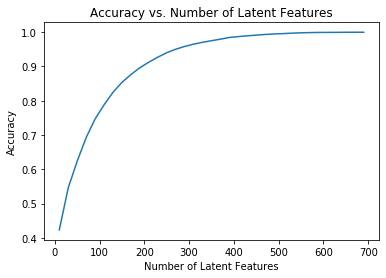

In [72]:
# Checking Results for Training Set

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Replacing amount of latent features in all matrices in for loop and checking the results.
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_train_lat,  np.diag(s_train[:k])), vt_train_lat))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [73]:
valid_test_users = list(set(df_train.user_id.unique()) & set(df_test.user_id.unique()))
valid_test_users = [int(x) for x in valid_test_users]

user_item_test_subset = user_item_test.loc[valid_test_users]

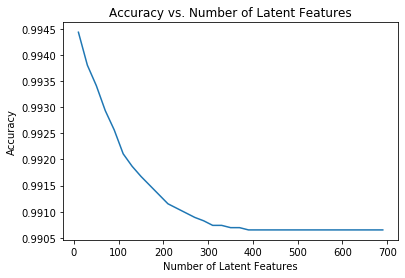

In [74]:
# Checking Results for Test Set

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Replacing amount of latent features in all matrices in for loop and checking the results.
    s_test_lat, u_test_lat, vt_test_lat = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_test_lat,  s_test_lat),  vt_test_lat))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

I found that accuracy is improving in the training set with a bigger amount of latent factors. On the other hand, accuracy decreases with a higher amount of latent features in the test set though. Therefore the higher the amount of latent features, the model appears to be overfitting to the training data and doesn't generalize well to real test data. I guess we need an early cut-off for latent features, before accuracy for the test set is actually going down.

Ideally I would use a combination of multiple recommendation mechanisms. For new users who have not yet seen any articles. we are facing the cold start problem. For those users I would provide recommendations based on an overall ranking, such as recommending the articles with the mmost total interactions in the dataset first. Also a knowledge based ranking could be introduced. We could first categorize articles into different categories, such as "Deep Leearning" and let the user filter by these categories. One could then display the top-ranked articles for each of these categories. For users who have already read articles we can switch to using collaborative filtering. SVD based recommendation can further enhance our recommendations for known users. 